To update a quaternion [q_w, q_x, q_y, q_z] given an angular velocity vector [\omega_x, \omega_y, \omega_z] and a time step \Delta t, you can use the quaternion integration formula based on the angular velocity.


In [56]:
import sys
import pykitti
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

sys.path.append('/app/src')

from src.internal.extended_common import State

dataset = pykitti.raw('/app/data/KITTI', '2011_09_30', '0018')

In [2]:
def quaternion_multiply(q1, q2):
    """Multiply two quaternions. Format: [w, x, y, z]"""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def update_quaternion(q, omega, dt):
    """
    Update quaternion using angular velocity.

    Parameters:
        q: np.array [qw, qx, qy, qz] - current quaternion
        omega: np.array [wx, wy, wz] - angular velocity in rad/s
        dt: float - delta time in seconds

    Returns:
        np.array [qw, qx, qy, qz] - updated quaternion
    """
    omega_quat = np.concatenate([[0], omega])  # [0, wx, wy, wz]
    q_dot = 0.5 * quaternion_multiply(q, omega_quat)
    q_new = q + q_dot * dt
    return q_new / np.linalg.norm(q_new)  # Normalize to unit quaternion

# Example usage:
q = np.array([1.0, 0.0, 0.0, 0.0])  # Identity quaternion
omega = np.array([0.1, 0.2, 0.3])   # rad/s
dt = 0.01                           # seconds

q_new = update_quaternion(q, omega, dt)
print("Updated quaternion:", q_new)

Updated quaternion: [9.99998250e-01 4.99999125e-04 9.99998250e-04 1.49999738e-03]


## Exponential Map Integration

In [3]:
def update_quaternion_expmap(q, omega, dt):
    """Quaternion update using exponential map."""
    theta = np.linalg.norm(omega) * dt
    if theta < 1e-8:
        return q  # Avoid division by zero

    axis = omega / np.linalg.norm(omega)
    half_theta = 0.5 * theta
    sin_half_theta = np.sin(half_theta)
    delta_q = np.array([
        np.cos(half_theta),
        axis[0] * sin_half_theta,
        axis[1] * sin_half_theta,
        axis[2] * sin_half_theta
    ])
    q_new = quaternion_multiply(delta_q, q)
    return q_new / np.linalg.norm(q_new)


## Runge-Kutta 4th order approximation

In [4]:
def quaternion_derivative(q, omega):
    omega_quat = np.concatenate([[0], omega])
    return 0.5 * quaternion_multiply(q, omega_quat)

def update_quaternion_rk4(q, omega, dt):
    """Quaternion update using 4th-order Runge-Kutta."""
    k1 = quaternion_derivative(q, omega)
    k2 = quaternion_derivative(q + 0.5 * dt * k1, omega)
    k3 = quaternion_derivative(q + 0.5 * dt * k2, omega)
    k4 = quaternion_derivative(q + dt * k3, omega)

    q_new = q + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return q_new / np.linalg.norm(q_new)

In [5]:
q = np.array([1.0, 0.0, 0.0, 0.0])
omega = np.array([0.1, 0.2, 0.3])  # rad/s
dt = 0.01

q_exp = update_quaternion_expmap(q, omega, dt)
q_rk4 = update_quaternion_rk4(q, omega, dt)

print("Exponential map:", q_exp)
print("Runge-Kutta 4:", q_rk4)

Exponential map: [9.99998250e-01 4.99999708e-04 9.99999417e-04 1.49999913e-03]
Runge-Kutta 4: [9.99998250e-01 4.99999708e-04 9.99999417e-04 1.49999912e-03]


## Euler-Rodrigues rotation

In [18]:
def skewed_symetric_matrix(w):
    wx, wy, wz = w
    return np.array([ # w, x, y, z
            [0, -wx, -wy, -wz],
            [wx, 0, wz, -wy],
            [wy, -wz, 0, wx],
            [wz, wy, -wx, 0]
        ])

def update_quaternion_euler_rodorigues(q, omega, dt):
    w_norm = np.linalg.norm(omega)
    _w = skewed_symetric_matrix(omega)
    A = np.cos(0.5 * w_norm * dt) * np.eye(4)
    B = 1 / w_norm * np.sin(0.5 * w_norm * dt) * _w
    q = A @ q + B @ q

    return q

In [19]:
q = np.array([1.0, 0.0, 0.0, 0.0])
omega = np.array([0.1, 0.2, 0.3])  # rad/s
dt = 0.01

q_exp = update_quaternion_euler_rodorigues(q, omega, dt)

print("Euler Rodorigues rotation:", q_exp)

Euler Rodorigues rotation: [9.99998250e-01 4.99999708e-04 9.99999417e-04 1.49999913e-03]


In [20]:
timestamps = dataset.timestamps

euler_estimates = []
exp_estimates = []
rk4_estimates = []
euler_rodorigues = []
ground_truth = []
ts = []

_packet = dataset.oxts[0].packet
w = np.array([_packet.roll, _packet.pitch, _packet.yaw])
q = State.get_quaternion_from_euler_angle(w).flatten()

q1 = q.copy()  # Initial quaternion
q2 = q.copy()  # Initial quaternion for exponential map
q3 = q.copy()  # Initial quaternion for Runge-Kutta 4
q4 = q.copy()  # Initial quaternion for Euler-Rodrigues

euler_estimates.append(w)
exp_estimates.append(w)
rk4_estimates.append(w)
euler_rodorigues.append(w)
ground_truth.append(w)

last_timestamp = None
time_elapse = 0
ts.append(time_elapse)

b = np.random.normal(0, 1e-5, size=omega.shape)  # Adding noise

for (oxts, timestamp) in zip(dataset.oxts, timestamps):
    t = datetime.timestamp(timestamp)
    if last_timestamp is None:
        last_timestamp = t
        continue
    dt = (t - last_timestamp)
    time_elapse += dt

    last_timestamp = t

    packet = oxts.packet
    omega = np.array([packet.wx, packet.wy, packet.wz])
    angle = np.array([packet.roll, packet.pitch, packet.yaw])

    b += np.random.normal(0, 1e-5, size=omega.shape)  # Adding noise

    omega = omega
    q1 = update_quaternion(q1, omega, dt)
    q2 = update_quaternion_expmap(q2, omega, dt)
    q3 = update_quaternion_rk4(q3, omega, dt)
    q4 = update_quaternion_euler_rodorigues(q4, omega, dt)

    w1 = State.get_euler_angle_from_quaternion_vector(q1).flatten()
    w2 = State.get_euler_angle_from_quaternion_vector(q2).flatten()
    w3 = State.get_euler_angle_from_quaternion_vector(q3).flatten()
    w4 = State.get_euler_angle_from_quaternion_vector(q4).flatten()

    euler_estimates.append(w1)
    exp_estimates.append(w2)
    rk4_estimates.append(w3)
    euler_rodorigues.append(w4)
    ground_truth.append(angle)
    ts.append(time_elapse)


euler_estimates = np.array(euler_estimates)
exp_estimates = np.array(exp_estimates)
rk4_estimates = np.array(rk4_estimates)
euler_rodorigues = np.array(euler_rodorigues)
ground_truth = np.array(ground_truth)
ts = np.array(ts)


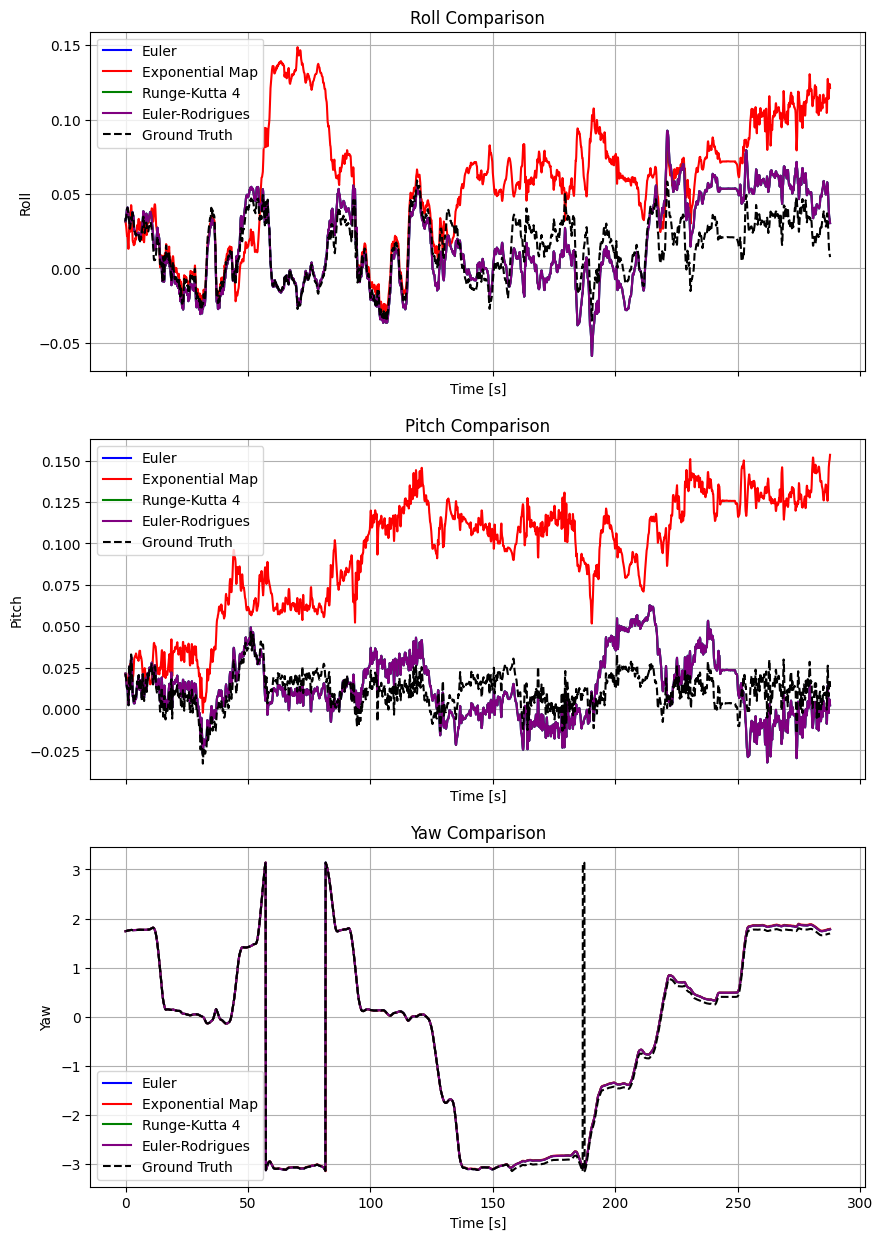

In [21]:
# Visualize the results
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

for i, label in enumerate(['Roll', 'Pitch', 'Yaw']):
    axs[i].plot(ts, euler_estimates[:, i], label='Euler', color='blue')
    axs[i].plot(ts, exp_estimates[:, i], label='Exponential Map', color='red')
    axs[i].plot(ts, rk4_estimates[:, i], label='Runge-Kutta 4', color='green')
    axs[i].plot(ts, euler_rodorigues[:, i], label='Euler-Rodrigues', color='purple')
    axs[i].plot(ts, ground_truth[:, i], label='Ground Truth', color='black', linestyle='--')

    axs[i].set_ylabel(label)
    axs[i].legend()
    axs[i].grid()
    axs[i].set_xlabel("Time [s]")
    axs[i].set_title(f"{label} Comparison")
